In [1]:
%pip install tensorflowjs

In [2]:

#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# data_dir='/content/drive/MyDrive/butterflyml/Butterfly/butterfly_photos/'
# print(data_dir)
data_dir='C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages'
print(data_dir)

C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages


In [5]:
data_dir=tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 2594 files belonging to 4 classes.


In [6]:
count = 0
dirs = os.listdir('C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/')
for dir in dirs:
    files = list(os.listdir('C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/'+dir))
    print( dir +' Folder has '+ str(len(files)) + 'C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/')

Butterfly Folder has 856C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/
Eggs Folder has 112C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/
Larvae Folder has 659C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/
Pupae Folder has 967C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/


In [7]:
base_dir = 'C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/'
img_size = 180
batch = 32

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 2594 files belonging to 4 classes.
Using 2076 files for training.
Found 2594 files belonging to 4 classes.
Using 518 files for validation.


In [9]:
lifestages_names = train_ds.class_names
lifestages_names

['Butterfly', 'Eggs', 'Larvae', 'Pupae']

In [10]:
import matplotlib.pyplot as plt

In [11]:
print(len(train_ds))
for element in train_ds.take(1):
    print(element)


65
(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
array([[[[155.80333   , 161.80333   , 161.80333   ],
         [144.14223   , 153.34221   , 150.24222   ],
         [152.45555   , 165.95555   , 154.45555   ],
         ...,
         [177.4611    , 178.4611    , 160.4611    ],
         [197.79855   , 200.86855   , 183.66835   ],
         [191.90044   , 199.90044   , 186.90044   ]],

        [[135.46667   , 147.46667   , 147.46667   ],
         [145.7367    , 150.27003   , 156.4567    ],
         [140.3       , 143.        , 141.3       ],
         ...,
         [170.93333   , 171.23334   , 157.46666   ],
         [194.89853   , 196.89853   , 183.79843   ],
         [201.83333   , 206.83333   , 199.83333   ]],

        [[190.25      , 205.25      , 202.25      ],
         [119.927734  , 128.92775   , 131.67773   ],
         [167.94444   , 167.94444   , 175.94444   ],
         ...,
         [187.44444   , 180.83334   , 170.05556   ],
         [209.49898   , 209.49898   , 199.4

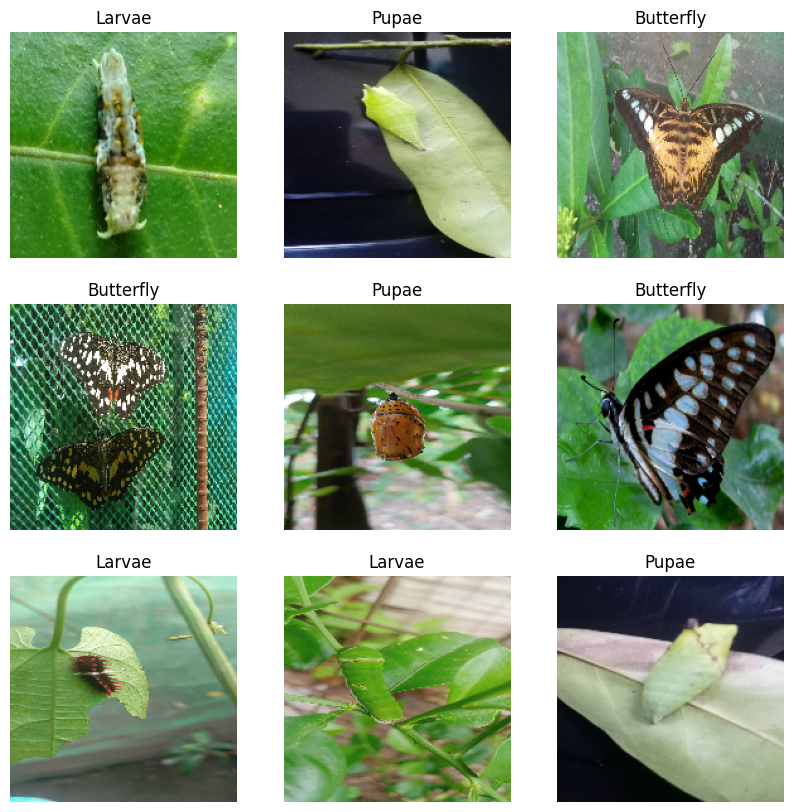

In [12]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(lifestages_names[labels[i]])
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [15]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

##Data AUgmentation

In [16]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

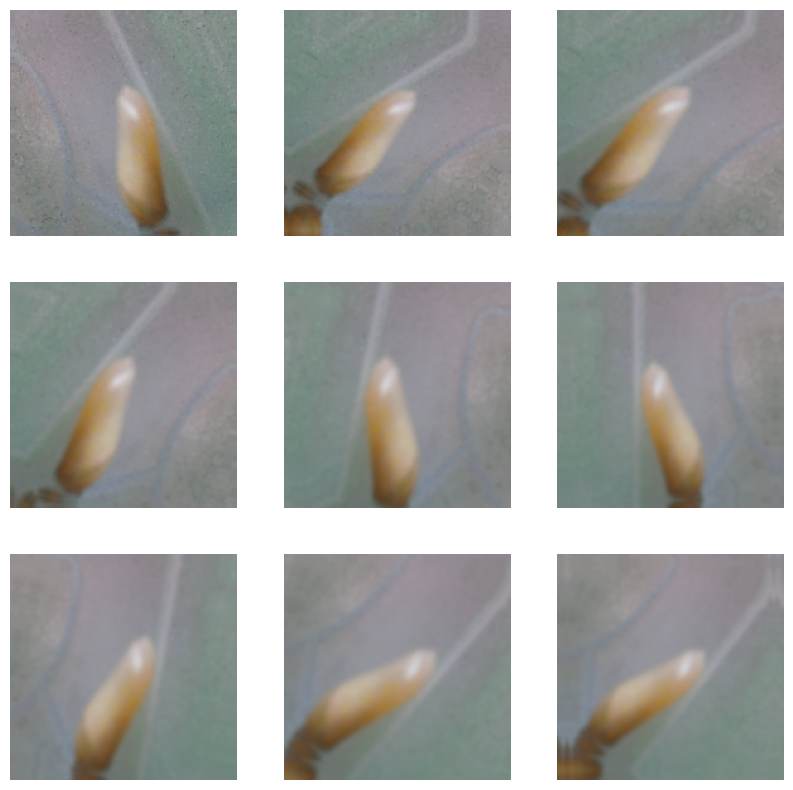

In [17]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

##Model Creation

In [18]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [21]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15


65/65 [==============================] - 40s 581ms/step - loss: 0.8966 - accuracy: 0.6623 - val_loss: 0.6991 - val_accuracy: 0.7819
Epoch 2/15
65/65 [==============================] - 13s 193ms/step - loss: 0.5158 - accuracy: 0.8189 - val_loss: 0.5727 - val_accuracy: 0.8340
Epoch 3/15
65/65 [==============================] - 12s 187ms/step - loss: 0.4282 - accuracy: 0.8603 - val_loss: 0.5243 - val_accuracy: 0.8456
Epoch 4/15
65/65 [==============================] - 12s 183ms/step - loss: 0.3818 - accuracy: 0.8724 - val_loss: 0.4497 - val_accuracy: 0.8436
Epoch 5/15
65/65 [==============================] - 12s 183ms/step - loss: 0.3204 - accuracy: 0.8940 - val_loss: 0.3238 - val_accuracy: 0.9266
Epoch 6/15
65/65 [==============================] - 12s 188ms/step - loss: 0.2906 - accuracy: 0.9114 - val_loss: 0.4017 - val_accuracy: 0.9073
Epoch 7/15
65/65 [==============================] - 24s 370ms/step - loss: 0.2899 - accuracy: 0.9027 - val_loss: 0.4301 - val_accuracy: 0.89

In [22]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + lifestages_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [23]:
classify_images('C:/Users/jerwin/Documents/GitHub/butterfly_photos/stages/Pupae/PupaeCommonLime2.jpg')

1/1 [==============================] - 2s 2s/step


'The Image belongs to Larvae with a score of 72.36493229866028'

In [24]:
model.save('C:/Users/jerwin/Documents/GitHub/bilabila/model/model_Life_Stages.keras')

In [25]:
model.save('C:/Users/jerwin/Documents/GitHub/bilabila/model/model_Life_Stages.h5')

c:\Users\jerwin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model = load_model('C:/Users/jerwin/Documents/GitHub/bilabila/model/model_Life_Stages.h5')


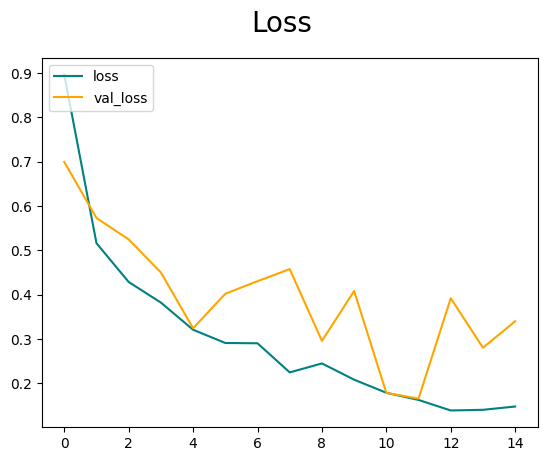

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

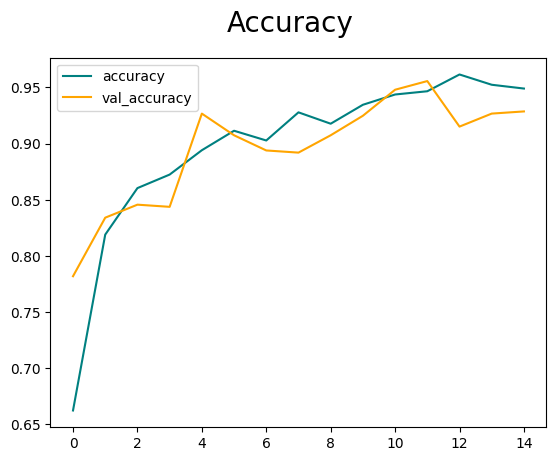

In [28]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
# Check the loaded model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [30]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("Life_Stages.json", "w") as json_file:
    json_file.write(model_json)


In [31]:
from tensorflow.keras.models import load_model


In [32]:
model = load_model('C:/Users/jerwin/Documents/GitHub/bilabila/model/model_Life_Stages.h5')

In [33]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("Life_Stages.json", "w") as json_file:
    json_file.write(model_json)


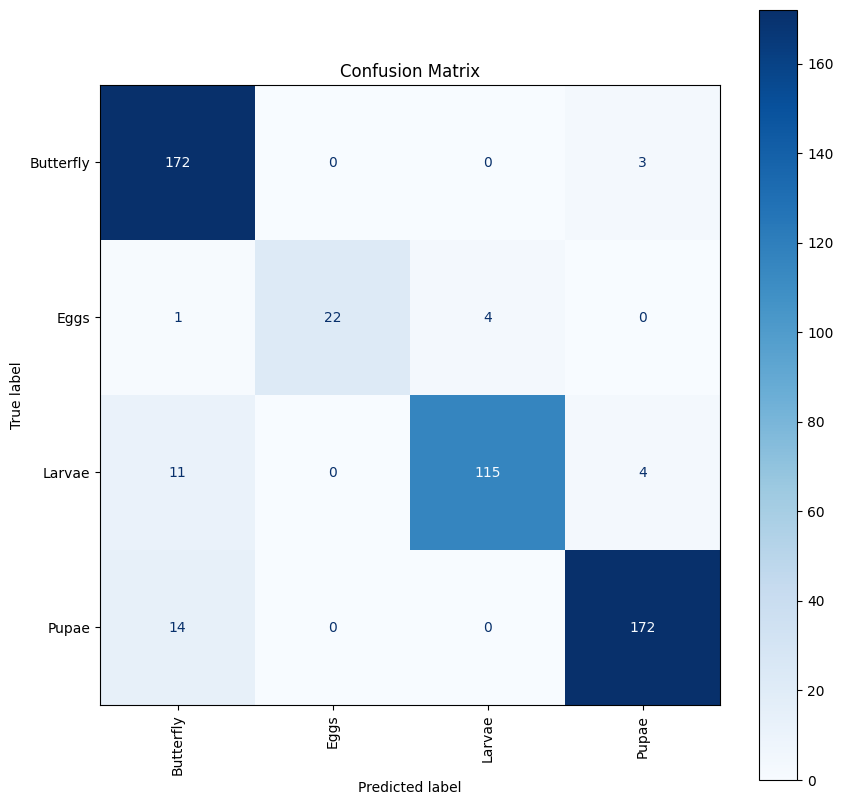

F1 Score (macro): 0.9216
F1 Score (weighted): 0.9286


In [34]:
# ...existing code...

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Evaluate model and plot confusion matrix + F1 score
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    img_array = tf.expand_dims(images, 0)  # Add batch dimension
    preds = model.predict(img_array, verbose=0)
    pred_label = np.argmax(preds, axis=1)[0]
    y_true.append(labels.numpy())
    y_pred.append(pred_label)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lifestages_names )
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# F1 Score (macro and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
# ...existing code...